In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlrd
import geopandas as gpd

In [2]:
RESOURCE_MAX = .5

# normalization and aggregation structure
INDICATORS = {
    'overall':{
        'crit':{
            'antimony':  {'vmax':RESOURCE_MAX},
            'beryllium': {'vmax':RESOURCE_MAX},
            'bismuth':   {'vmax':RESOURCE_MAX},
            'cadmium':   {'vmax':RESOURCE_MAX},
            'chromium':  {'vmax':RESOURCE_MAX},
            'cobalt':    {'vmax':RESOURCE_MAX},
            'graphite':  {'vmax':RESOURCE_MAX},
            'lithium':   {'vmax':RESOURCE_MAX},
            'magnesium': {'vmax':RESOURCE_MAX},
            'manganese': {'vmax':RESOURCE_MAX},
            'molybdenum':{'vmax':RESOURCE_MAX},
            'niobium':   {'vmax':RESOURCE_MAX},
            'palladium': {'vmax':RESOURCE_MAX},
            'platinum':  {'vmax':RESOURCE_MAX},
            'ree':       {'vmax':RESOURCE_MAX},
            'rhodium':   {'vmax':RESOURCE_MAX},
            'titanium':  {'vmax':RESOURCE_MAX},
            'tungsten':  {'vmax':RESOURCE_MAX},
            'uranium':   {'vmax':RESOURCE_MAX},
            'zirconium': {'vmax':RESOURCE_MAX},
        },
        'metals':{
            'aluminum':  {'vmax':RESOURCE_MAX},
            'copper':    {'vmax':RESOURCE_MAX},
            'gold':      {'vmax':RESOURCE_MAX},
            'silver':    {'vmax':RESOURCE_MAX},
            'nickel':    {'vmax':RESOURCE_MAX},
            'zinc':      {'vmax':RESOURCE_MAX},
            'lead':      {'vmax':RESOURCE_MAX},
            'steel':     {'vmax':RESOURCE_MAX},
            'tin':       {'vmax':RESOURCE_MAX},
        },
        'ag':{
            'coffee':    {'vmax':RESOURCE_MAX},
            'maize':     {'vmax':RESOURCE_MAX},
            'milk':      {'vmax':RESOURCE_MAX},
            'palm':      {'vmax':RESOURCE_MAX},
            'pork':      {'vmax':RESOURCE_MAX},
            'poultry':   {'vmax':RESOURCE_MAX},
            'rice':      {'vmax':RESOURCE_MAX},
            'soy':       {'vmax':RESOURCE_MAX},
            'sugar':     {'vmax':RESOURCE_MAX},
            'wheat':     {'vmax':RESOURCE_MAX},
            'beef':      {'vmax':RESOURCE_MAX},
        },
        'energy':{
            'gas':       {'vmax':RESOURCE_MAX},
            'oil':       {'vmax':RESOURCE_MAX},
            'coal':      {'vmax':RESOURCE_MAX},
        },
        'mil_ex': {'log':True, 'winsor':2.5},
        'arms': {
             'arms_ex': {'vmax':.5},
             'arms_im': {'vmax':.2},
        },
        'unga': {},
        'aid': {'vmax':.1},
        'trade':{'log':True, 'winsor':2.5},
        'fdi':{'log':True, 'winsor':2.5},
        'students':{
            'student_in':{'log':True, 'winsor':2.5},
            'student_out':{'log':True, 'winsor':2.5},
        }
    },
    'resources':{
        'crit',
        'metals',
        'ag',
        'energy',
    },
    'mil':{
        'arms',
        'mil_ex',
    },
    'diplo':{
        'unga',
        'aid',
    },
    'soft':{
        'trade',
        'fdi',
        'students'
    }
}
def iterind(f, indicators=None, **kwargs):
    if indicators is None:
        indicators = INDICATORS
    for k,v in indicators.items():
        if (type(v) is dict and len(v) and not ('vmin' in v or 'vmax' in v or 'log' in v)):
            iterind(f, v, **kwargs)
        f(k, v, **kwargs)

In [3]:
countries = pd.read_csv('countries.csv')
countries = countries.set_index('iso_a3').drop('-99')
#shps = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
shps = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip')
shps.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,POLYGON ((33.90371119710453 -0.950000000000000...
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,서사하라,Westelijke Sahara,Sahara Zachodnia,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,POLYGON ((-8.665589565454809 27.65642588959236...
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,캐나다,Canada,Kanada,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,미국,Verenigde Staten van Amerika,Stany Zjednoczone,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [4]:
# read raw indicator values
dat = pd.read_csv('all_ind2.csv')
dat.set_index('iso', inplace=True)
dat['fdi_us'].loc[dat['fdi_us']==0] = np.nan
dat['fdi_cn'].loc[dat['fdi_cn']==0] = np.nan
dat['country'] = countries['name']
dat = dat[countries['primary']>0]
us_col = [c for c in dat if c[-2:]=='us']
cn_col = [c for c in dat if c[-2:]=='cn']
dat.at['USA', us_col] = np.nan
dat.at['CHN', cn_col] = np.nan
dat.loc[['USA', 'CHN']]

/usr/local/homebrew/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,country,aluminum_us,aluminum_cn,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,...,aid_us,aid_cn,unga_us,unga_cn,arms_ex_us,arms_im_us,arms_ex_cn,arms_im_cn,mil_ex_us,mil_ex_cn
iso,,,,,,,,,,,,,,,,,,,,,
USA,United States of America,NaN,0.0,NaN,0.001,NaN,0.051,NaN,0.002,NaN,...,NaN,0.0,NaN,0.18,NaN,NaN,0.0,0.0,NaN,23.0
CHN,China,0.001,NaN,0.524,NaN,0.0,NaN,0.752,NaN,0.046,...,0.0,NaN,0.18,NaN,0.0,0.0,NaN,NaN,7.0,NaN


In [5]:
# normalization
def norm(seq, vmin=None, vmax=None, log=False, winsor=False):
    if log:
        seq = seq+1
    if not vmin:
        if winsor:
            vmin = np.nanpercentile(seq, winsor)
        else:
            vmin = np.min(seq)
    if not vmax:
        if winsor:
            vmax = np.nanpercentile(seq, 100-winsor)
        else:
            vmax = np.max(seq)
    if log:
        seq = np.log(seq)
        vmin = np.log(vmin)
        vmax = np.log(vmax)
    s = (seq - vmin)/(vmax - vmin)
    s = np.clip(s, 0, 1)
    return s

In [6]:
# aggregation
out = pd.DataFrame(index=dat.index)
out['country'] = dat['country']

def agg(ind, args, df=out, max_resources=False):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if args == {} or 'vmin' in args or 'vmax' in args or 'log' in args:
        if usi in dat:
            if not 'vmax' in args:
                if 'winsor' in args:
                    args['vmax'] = np.nanpercentile(np.vstack((dat[usi], dat[cni])), 100-args['winsor'])
                else:
                    args['vmax'] = np.nanmax(np.vstack((dat[usi], dat[cni])))
            df[usi] = norm(dat[usi], **args)
            df.at['USA', usi] = np.nan
            df[cni] = norm(dat[cni], **args)
            df.at['CHN', cni] = np.nan
    else:
        usargs = ['{}_us'.format(arg) for arg in args]
        cnargs = ['{}_cn'.format(arg) for arg in args]
        df[usi] = np.nanmean(df[usargs], axis=1)
        df[cni] = np.nanmean(df[cnargs], axis=1)
        vmax = np.nanmax(np.vstack((df[usi], df[cni])))
        df[usi] = df[usi]/vmax
        df[cni] = df[cni]/vmax

iterind(agg, df=out)

# scale to 10x
out.loc[:, out.columns!='country']*=10
out.head()

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


,country,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,cadmium_cn,chromium_us,...,overall_us,overall_cn,resources_us,resources_cn,mil_us,mil_cn,diplo_us,diplo_cn,soft_us,soft_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,3.457487,1.646883,0.000000,0.000000,3.133333,0.000000,6.266667,4.937691,4.064324,1.398774
AGO,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,2.126886,3.971770,0.241992,2.110710,2.032548,2.077423,0.637624,5.440696,5.135500,4.299601
ALB,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,...,2.464780,1.134871,0.005192,0.065767,3.515731,0.000000,2.979538,2.442512,3.101163,1.845004
ARE,United Arab Emirates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,4.522989,3.198019,0.159438,0.555060,7.398430,0.066667,0.918812,4.579710,7.078666,5.353866
ARG,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,4.220648,3.018035,0.683280,0.749875,5.365882,0.000000,1.518812,4.532386,6.674838,4.758431


/usr/local/homebrew/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/homebrew/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


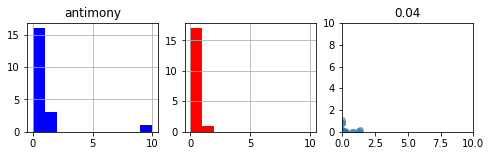

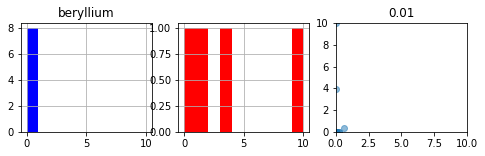

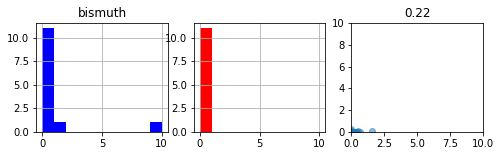

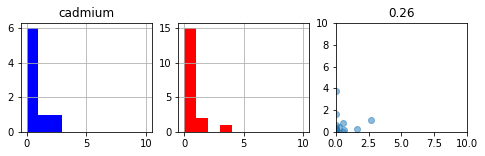

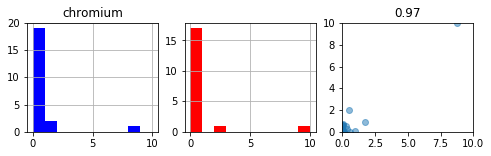

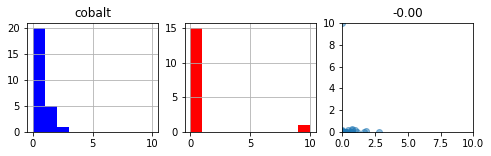

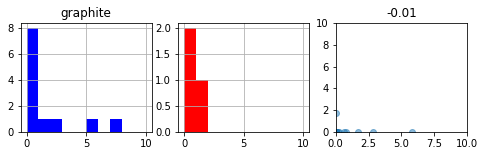

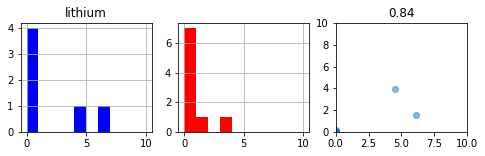

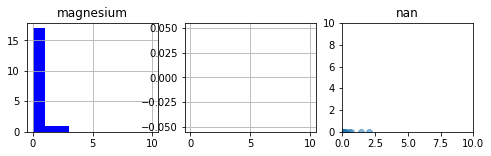

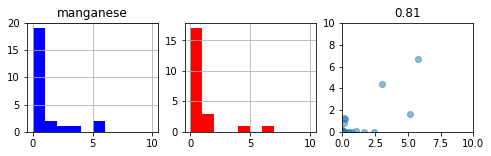

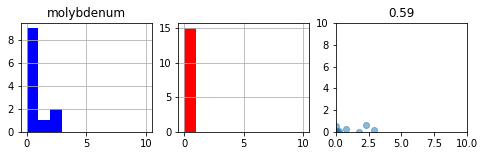

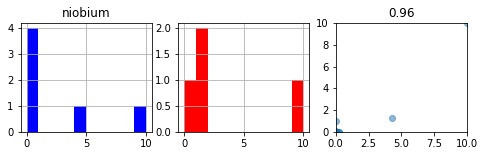

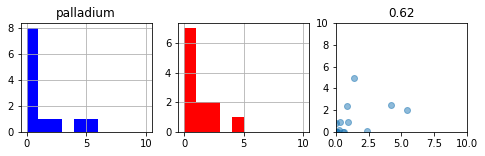

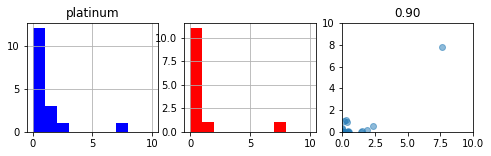

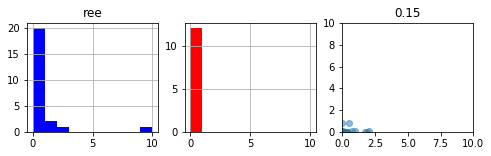

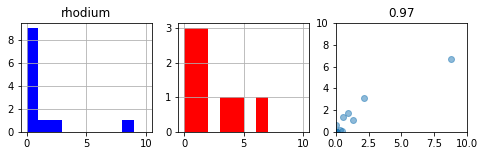

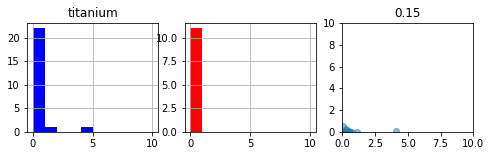

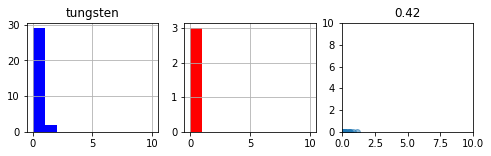

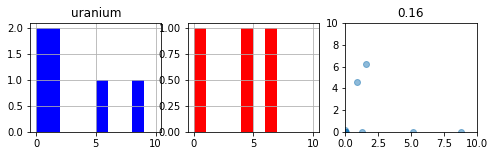

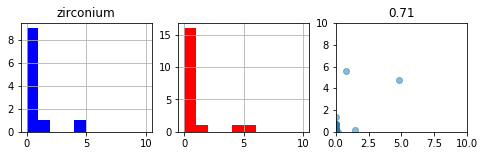

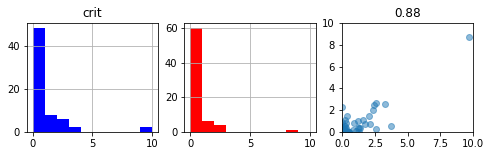

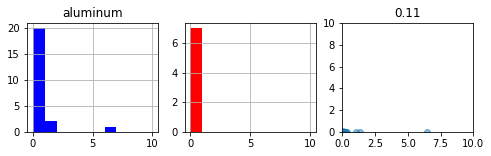

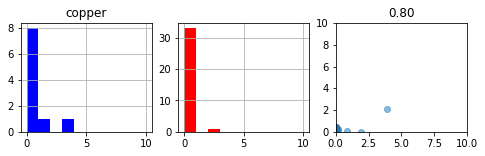

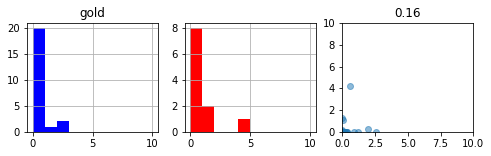

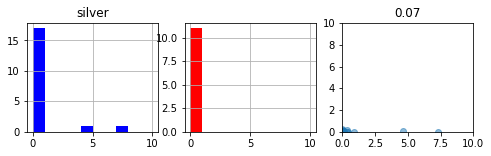

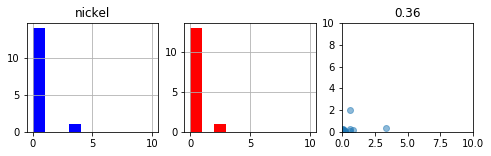

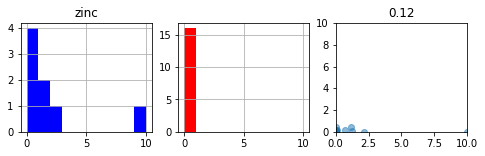

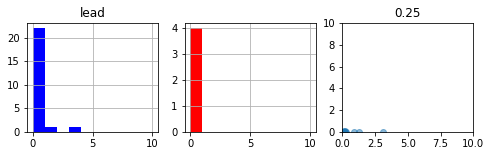

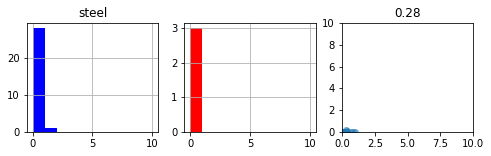

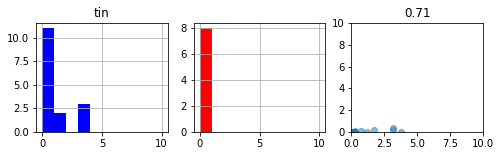

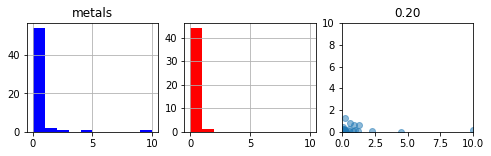

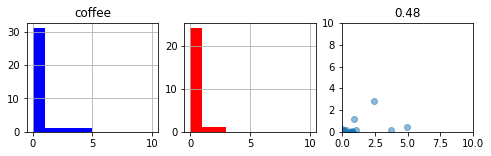

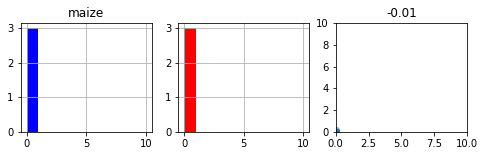

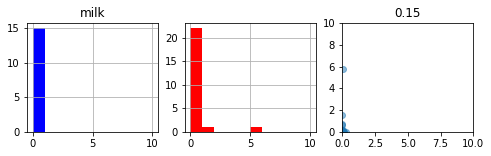

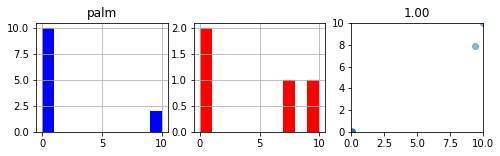

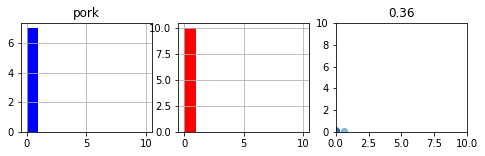

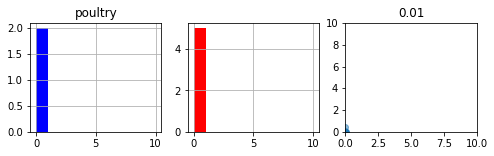

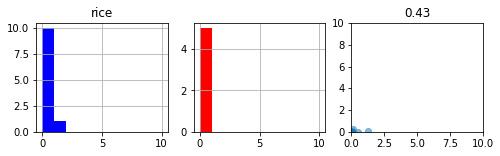

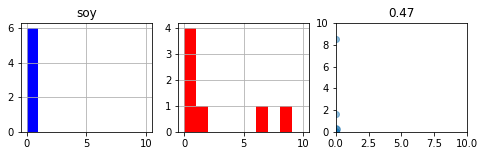

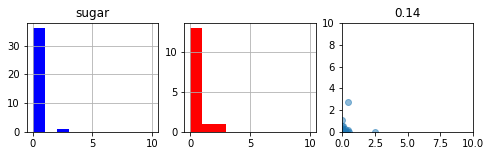

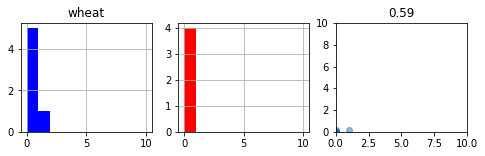

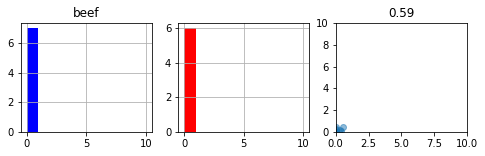

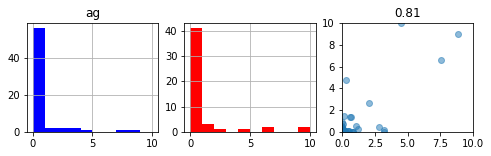

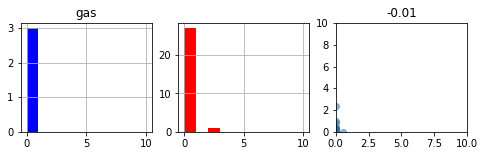

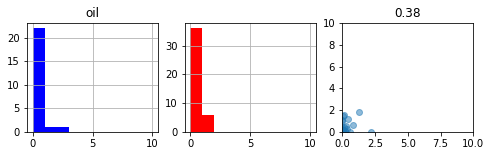

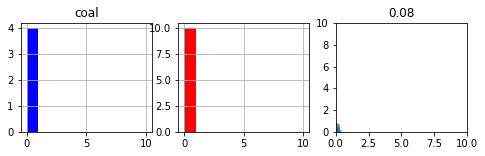

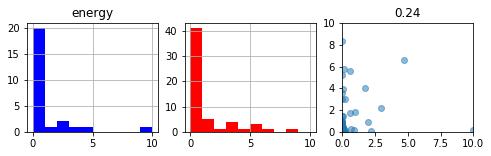

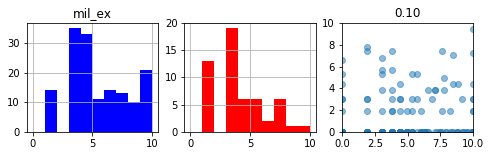

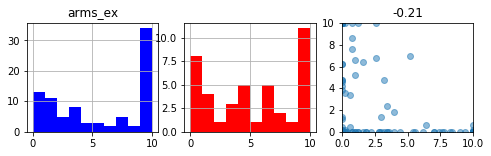

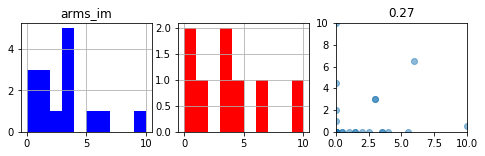

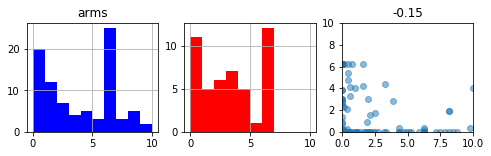

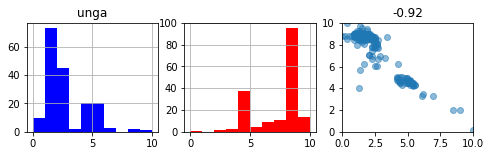

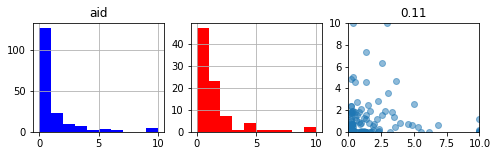

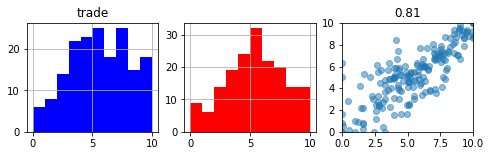

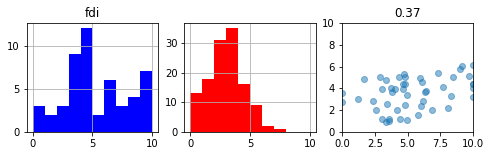

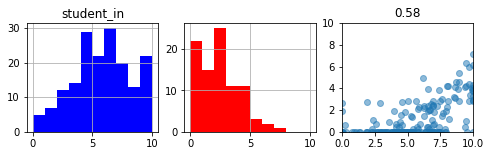

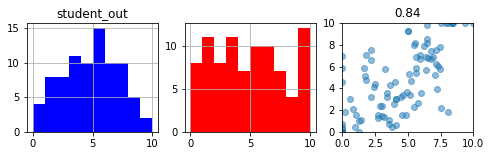

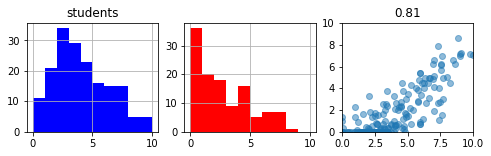

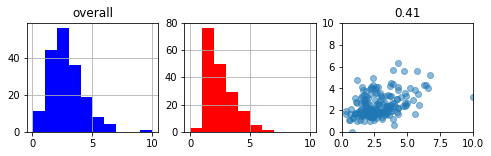

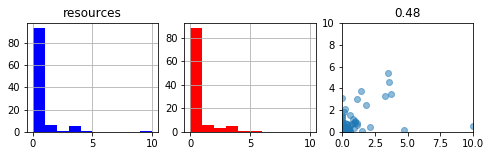

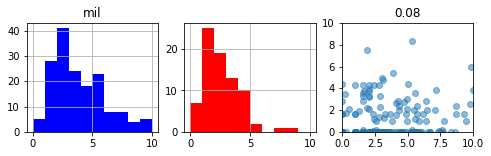

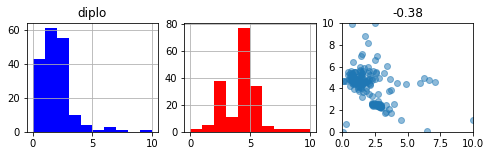

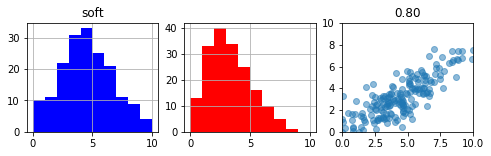

In [7]:
# plots
def plots(ind, *args, dat=dat, vmax=None, skipzeros=False):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        x = dat[usi].copy()
        y = dat[cni].copy()
        both = np.vstack((x,y))
        vmin = np.nanmin(both)
        if not vmax:
            vmax = np.nanmax(both)
        if skipzeros:
            x.loc[x==0] = np.nan
            y.loc[y==0] = np.nan
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        x.hist(ax=axs[0], color='b', range=(vmin, vmax))
        y.hist(ax=axs[1], color='r', range=(vmin, vmax))
        axs[2].scatter(dat[usi], dat[cni], alpha=.5)
        axs[2].set_xlim((vmin, vmax))
        axs[2].set_ylim((vmin, vmax))
        axs[0].set_title(ind)
        axs[2].set_title("{:0.2f}".format(dat[[usi,cni]].corr().iloc[1,0]))
        fig.show()
        
iterind(plots, dat=out, vmax=10, skipzeros=True)

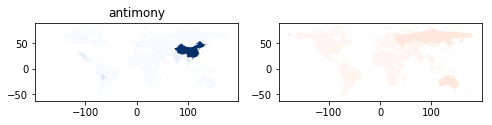

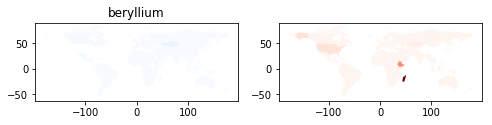

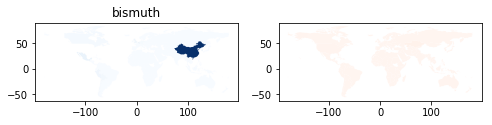

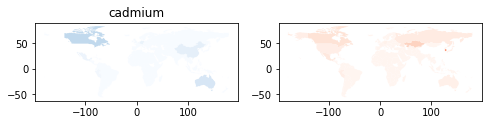

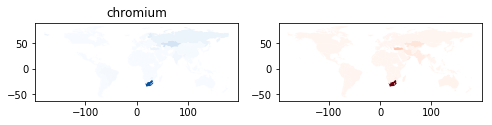

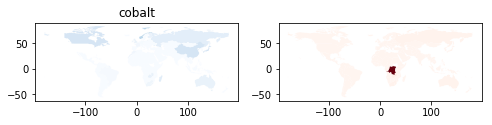

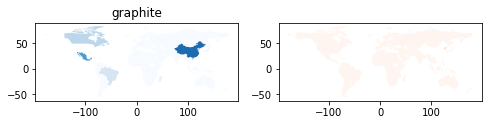

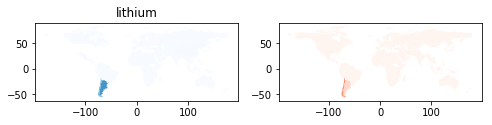

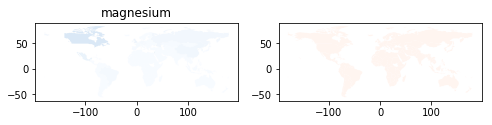

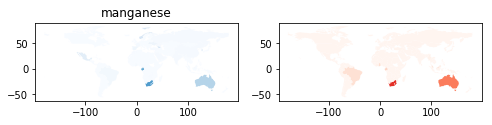

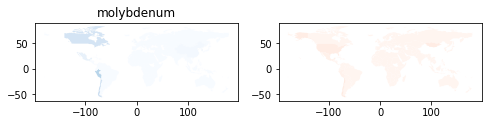

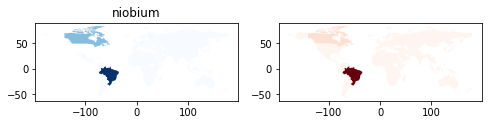

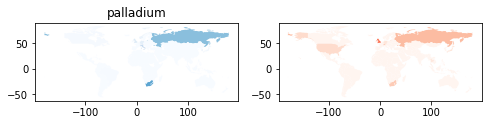

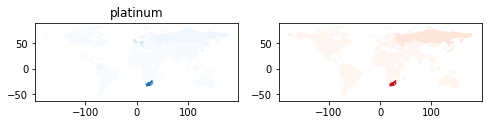

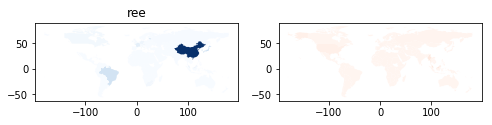

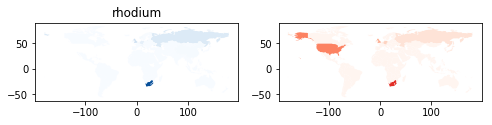

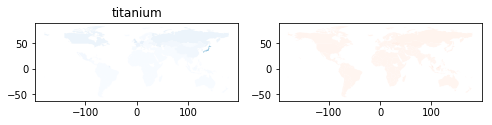

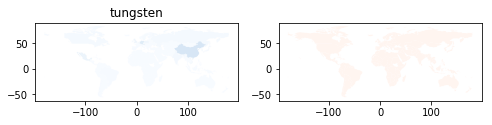

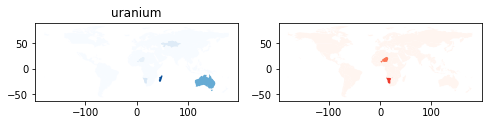

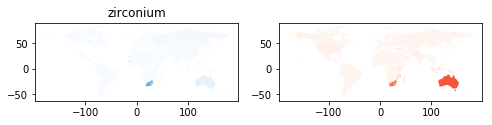

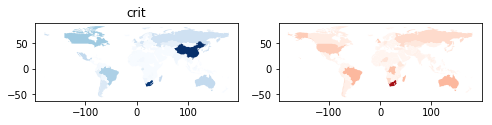

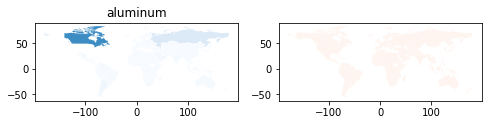

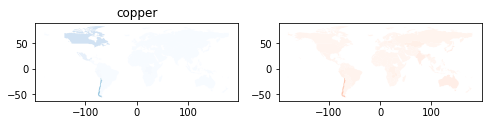

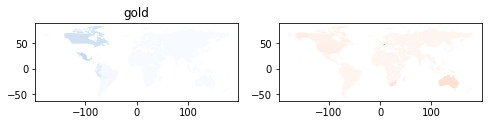

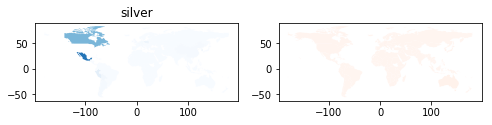

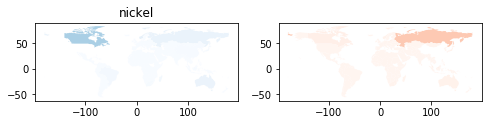

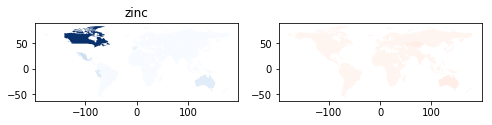

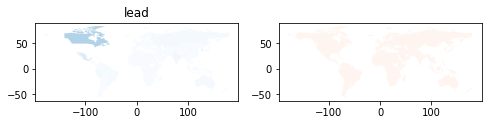

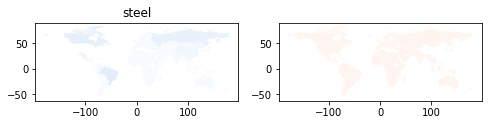

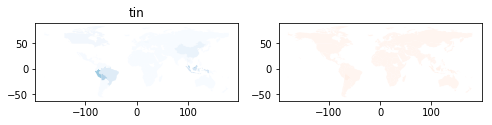

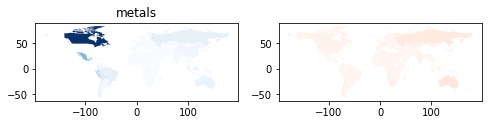

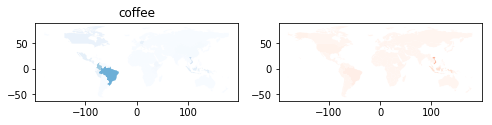

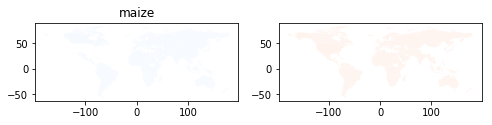

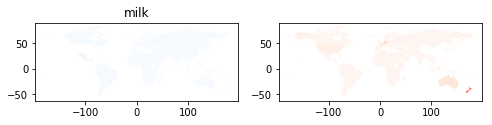

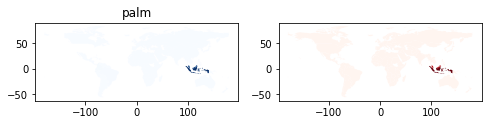

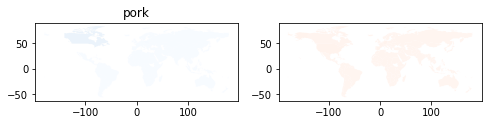

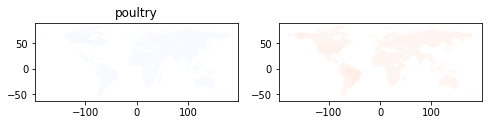

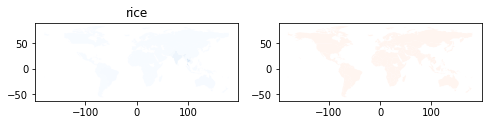

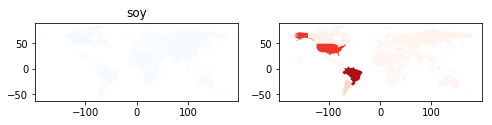

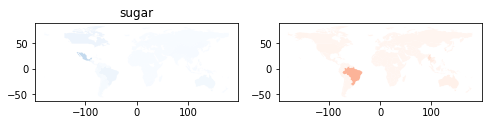

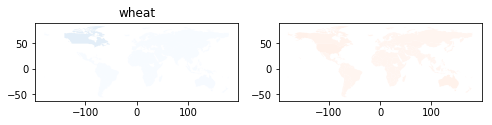

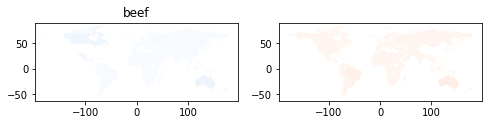

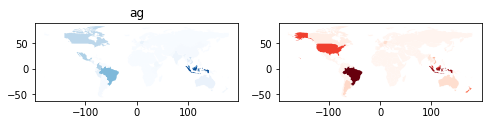

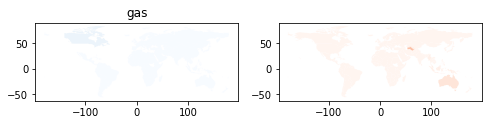

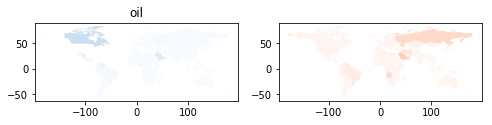

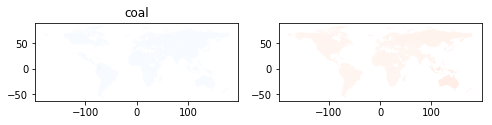

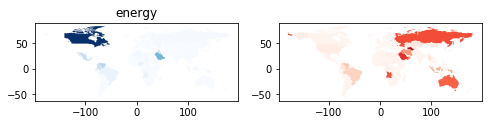

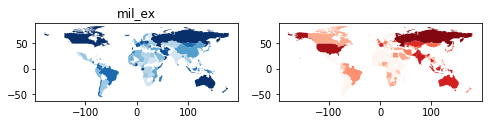

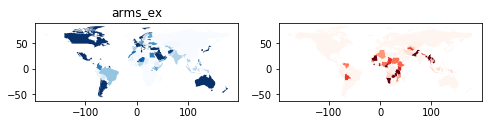

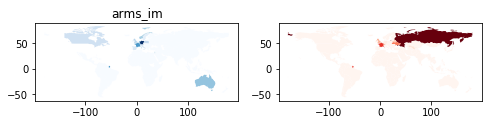

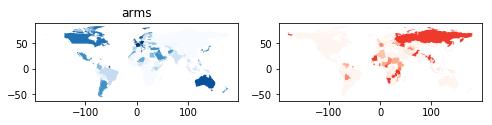

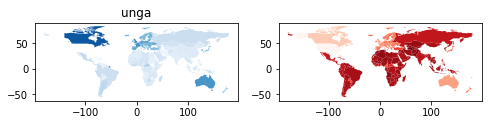

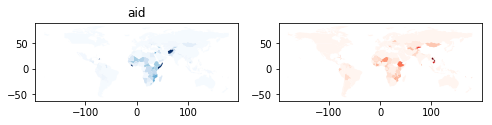

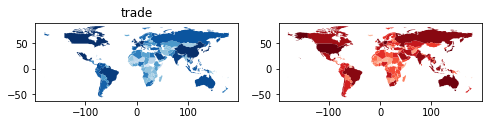

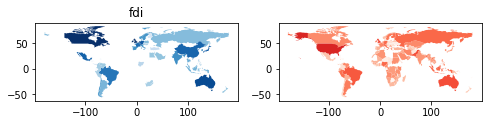

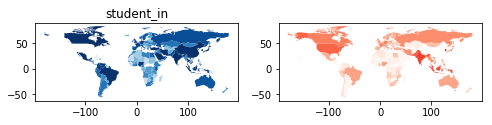

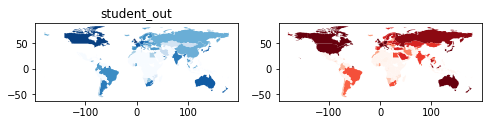

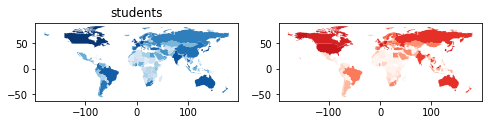

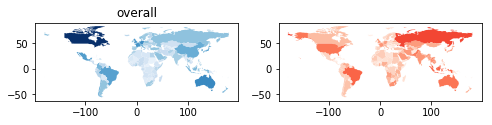

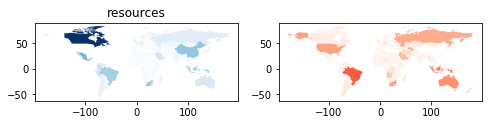

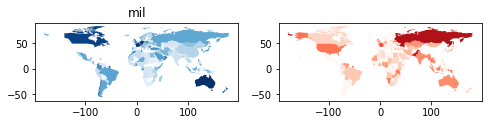

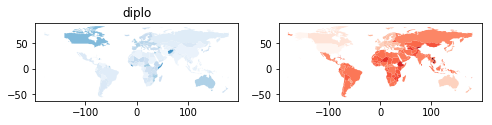

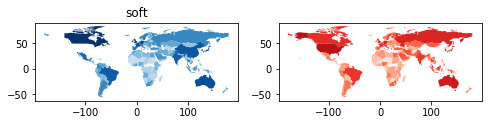

In [8]:
def maps(ind, *args, dat=dat, vmax=None):
    shp2 = shps.set_index('ADM0_A3').join(dat)
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        fig, axs = plt.subplots(1, 2, figsize=(8, 2))
        shp2[shp2[usi].notna()].plot(usi, ax=axs[0], cmap='Blues', vmax=vmax)
        shp2[shp2[cni].notna()].plot(cni, ax=axs[1], cmap='Reds', vmax=vmax)
        axs[0].set_title(ind)
        fig.show()
iterind(maps, dat=out, vmax=10)

In [9]:
def tops(ind, *args, dat=dat, n=10):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        print(ind)
        print(dat.set_index('country')[usi].sort_values(ascending=False).head(n))
        print(dat.set_index('country')[cni].sort_values(ascending=False).head(n))
        print('\n')
iterind(tops, dat=out)

antimony
country
China             10.00
Thailand           1.36
Bolivia            1.26
Belgium            1.22
Mexico             0.84
India              0.74
France             0.28
Peru               0.20
United Kingdom     0.20
Japan              0.18
Name: antimony_us, dtype: float64
country
Tajikistan    1.12
Russia        0.84
Australia     0.78
Kyrgyzstan    0.12
Myanmar       0.12
Thailand      0.12
Peru          0.06
Kazakhstan    0.06
Bolivia       0.06
Laos          0.06
Name: antimony_cn, dtype: float64


beryllium
country
Kazakhstan        0.60
Czech Republic    0.24
United Kingdom    0.22
Mexico            0.10
Philippines       0.06
Canada            0.04
Austria           0.04
France            0.02
Zimbabwe          0.00
Guinea            0.00
Name: beryllium_us, dtype: float64
country
Madagascar                        10.00
Ethiopia                           3.90
United States of America           1.02
Kazakhstan                         0.36
Zimbabwe                

country
South Korea                 10.000000
Japan                       10.000000
Germany                     10.000000
United States of America    10.000000
Australia                    9.828410
Malaysia                     9.536672
Vietnam                      9.480911
Russia                       9.325894
Brazil                       9.318857
Singapore                    9.263811
Name: trade_cn, dtype: float64


fdi
country
Ireland           10.000000
Canada            10.000000
United Kingdom    10.000000
Luxembourg        10.000000
Netherlands       10.000000
Singapore          9.674020
Switzerland        9.154112
Australia          8.957180
Germany            8.453494
Japan              8.308713
Name: fdi_us, dtype: float64
country
United States of America    7.016890
United Kingdom              6.128426
Switzerland                 6.054030
Australia                   5.758132
Pakistan                    5.683557
Brazil                      5.446480
Malaysia                    

In [10]:
out.to_csv('scored_values.csv')

In [11]:
shps.set_index('ADM0_A3').join(out).to_file('nsi.shp')
